<a href="https://colab.research.google.com/github/afrahhassan/afrahhassan/blob/main/assignment2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Introduction
## Task
This report will analyse the methodology used to complete assignment 2 of the course Machine Learning (COSC2673/2793). The objective of the assignment is to develop a machine-learning system that can classify traffic sign images.

The project is divided into two tasks:


*   Classify images according to the shape of the given image.
*    Classify images according to type.



## Approach
Our goal is to be able to identify the best possible machine-learning algorithm to generate a model that can reliably and consistently predict whether the type of traffic sign is based on image recognition.

# **Contact to the Drive**

In [1]:
from google.colab import drive
import os
import csv
import numpy as np
from sklearn.model_selection import train_test_split
import pandas as pd
import cv2
from PIL import Image
from sklearn.preprocessing import LabelEncoder


In [2]:
!cp -r "/content/drive/MyDrive/Assignment2" .

cp: cannot stat '/content/drive/MyDrive/Assignment2': No such file or directory


In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [4]:
import zipfile
with zipfile.ZipFile('/content/drive/MyDrive/Assignment2/trafficsigns_dataset.zip', 'r') as zip_ref:
    zip_ref.extractall('./')

# **1. Data Exploration**
## **1.1 Image Visualization**

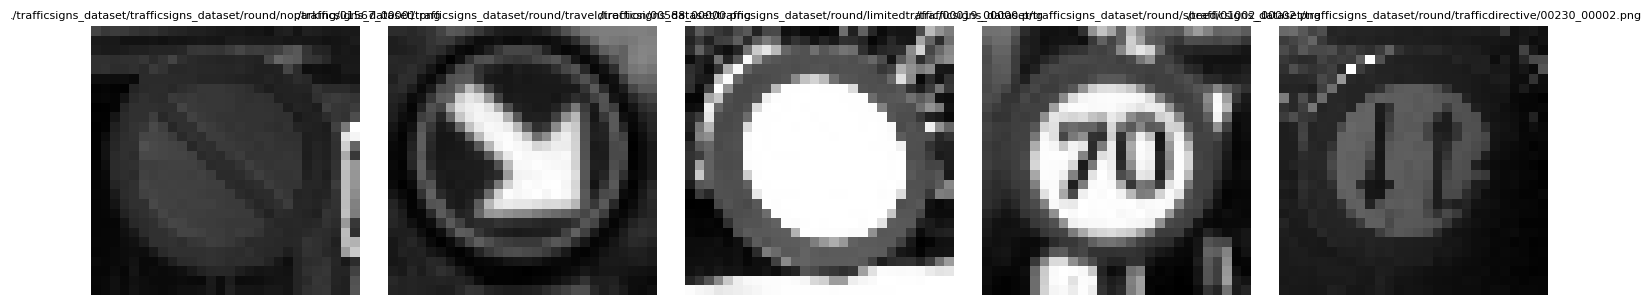

In [5]:
import os
import zipfile
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

# Path to the ZIP file and extraction directory
zip_path = '/content/drive/MyDrive/Assignment2/trafficsigns_dataset.zip'
extraction_path = './trafficsigns_dataset'

# Extracting the ZIP file
with zipfile.ZipFile(zip_path, 'r') as zip_ref:
    zip_ref.extractall(extraction_path)

# Function to display images
def plot_images(images, titles, rows=1, cols=5, figsize=(15, 3)):
    fig, axes = plt.subplots(rows, cols, figsize=figsize)
    axes = axes.ravel()
    for i in range(len(images)):
        axes[i].imshow(images[i], cmap='gray')
        axes[i].set_title(titles[i], fontsize=8)
        axes[i].axis('off')
    plt.tight_layout()
    plt.show()

# Function to collect images from multiple directories
def collect_images(directory, extension, num_images=5, cols=5):
    images = []
    titles = []
    # Walk through each folder and subfolder
    for root, dirs, files in os.walk(directory):
        file_list = [os.path.join(root, file) for file in files if file.endswith(extension)]
        if file_list:
            selected_files = file_list[:num_images]  # Take up to num_images from each folder
            images.extend([mpimg.imread(img) for img in selected_files])
            titles.extend(selected_files)
        if len(images) >= cols:  # Limit the total number of images to display
            break
    return images, titles

# Collect and display images
image_extensions = ('.jpeg', '.jpg', '.png')
images, titles = collect_images(extraction_path, image_extensions, num_images=1, cols=5)  # Adjust num_images to pick from each folder
plot_images(images, titles)




**Observations:**
- The traffic sign images exhibit a wide variety of shapes.
- Some signs have distinctive shapes (e.g., triangles, circles, octagons), while others have more complex shapes.
- The images also vary in terms of background complexity, with some signs having simple backgrounds and others having more cluttered backgrounds.
- These observations suggest that a machine-learning algorithm will need to be able to handle a diverse range of image characteristics in order to accurately classify the traffic signs.

## **1.2 Load Data into DataFrame**

In [6]:
import os
import cv2
import pandas as pd

def load_images_into_dataframes(data_dir):
    """
    Function to load images from a directory into separate Pandas DataFrames for shape and type.

    Args:
    - data_dir (str): Path to the directory containing the data.

    Returns:
    - shape_df (DataFrame): Pandas DataFrame containing shape data with images loaded.
    - type_df (DataFrame): Pandas DataFrame containing type data with images loaded.
    """
    shape_data = []
    type_data = []

    # Iterate through shape folders
    for shape_folder in os.listdir(data_dir):
        shape_folder_path = os.path.join(data_dir, shape_folder)

        # Skip non-directory files
        if not os.path.isdir(shape_folder_path):
            continue

        # Iterate through sign type folders
        for sign_type_folder in os.listdir(shape_folder_path):
            sign_type_folder_path = os.path.join(shape_folder_path, sign_type_folder)

            # Skip non-directory files
            if not os.path.isdir(sign_type_folder_path):
                continue

            # Iterate through image files
            for image_file in os.listdir(sign_type_folder_path):
                image_path = os.path.join(sign_type_folder_path, image_file)

                # Check if the file is an image
                if not image_path.endswith(('.jpg', '.jpeg', '.png', '.bmp', '.gif')):
                    print(f"Skipping non-image file: {image_path}")
                    continue

                # Load the image
                image = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)

                # Check if the image is null
                if image is None:
                    print(f"Skipping null image: {image_path}")
                    continue

                # Append image and labels to the respective data lists
                shape_data.append((image_path, image, shape_folder))
                type_data.append((image_path, image, sign_type_folder))

    # Create DataFrames from the collected data
    shape_df = pd.DataFrame(shape_data, columns=['image_path', 'image', 'shape_label'])
    type_df = pd.DataFrame(type_data, columns=['image_path', 'image', 'type_label'])

    return shape_df, type_df

# Example usage
# data_dir = "trafficsigns_dataset"
data_dir = "/content/drive/My Drive/Assignment2/trafficsigns_dataset"
shape_df, type_df = load_images_into_dataframes(data_dir)

print("Shape DataFrame:")
print(shape_df.head())

print("\nType DataFrame:")
print(type_df.head())


Skipping non-image file: /content/drive/My Drive/Assignment2/trafficsigns_dataset/triangle/warning/.DS_Store
Shape DataFrame:
                                          image_path  \
0  /content/drive/My Drive/Assignment2/trafficsig...   
1  /content/drive/My Drive/Assignment2/trafficsig...   
2  /content/drive/My Drive/Assignment2/trafficsig...   
3  /content/drive/My Drive/Assignment2/trafficsig...   
4  /content/drive/My Drive/Assignment2/trafficsig...   

                                               image shape_label  
0  [[60, 64, 47, 39, 46, 33, 30, 33, 19, 24, 15, ...      square  
1  [[73, 63, 59, 55, 46, 51, 52, 52, 61, 56, 57, ...      square  
2  [[255, 255, 255, 255, 255, 254, 254, 254, 255,...      square  
3  [[37, 31, 30, 31, 30, 42, 37, 36, 35, 37, 35, ...      square  
4  [[117, 88, 77, 96, 87, 72, 79, 91, 80, 78, 76,...      square  

Type DataFrame:
                                          image_path  \
0  /content/drive/My Drive/Assignment2/trafficsig...   
1  /co

## **1.3 Check the Data Set**

In [7]:
# Check the size of the Shape DataFrame
print("DataFrame Size:")
print(shape_df.shape)

# Display basic information about the Shape DataFrame
print("\nDataFrame Information:")
print(shape_df.info())

# Display descriptive statistics of the Shape DataFrame
print("\nDataFrame Descriptive Statistics:")
print(shape_df.describe())

DataFrame Size:
(3699, 3)

DataFrame Information:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3699 entries, 0 to 3698
Data columns (total 3 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   image_path   3699 non-null   object
 1   image        3699 non-null   object
 2   shape_label  3699 non-null   object
dtypes: object(3)
memory usage: 86.8+ KB
None

DataFrame Descriptive Statistics:
                                               image_path  \
count                                                3699   
unique                                               3699   
top     /content/drive/My Drive/Assignment2/trafficsig...   
freq                                                    1   

                                                    image shape_label  
count                                                3699        3699  
unique                                               3699           5  
top     [[60, 64, 47, 39, 46, 33, 30

In [8]:
# Check the size of the Type DataFrame
print("DataFrame Size:")
print(type_df.shape)

# Display basic information about the Type DataFrame
print("\nDataFrame Information:")
print(type_df.info())

# Display descriptive statistics of the Type DataFrame
print("\nDataFrame Descriptive Statistics:")
print(type_df.describe())

DataFrame Size:
(3699, 3)

DataFrame Information:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3699 entries, 0 to 3698
Data columns (total 3 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   image_path  3699 non-null   object
 1   image       3699 non-null   object
 2   type_label  3699 non-null   object
dtypes: object(3)
memory usage: 86.8+ KB
None

DataFrame Descriptive Statistics:
                                               image_path  \
count                                                3699   
unique                                               3699   
top     /content/drive/My Drive/Assignment2/trafficsig...   
freq                                                    1   

                                                    image type_label  
count                                                3699       3699  
unique                                               3699         16  
top     [[60, 64, 47, 39, 46, 33, 30, 33, 19

In [9]:
# Number of data points
num_data_points_1 = len(type_df)
print("Number of Data Points:", num_data_points_1)

num_data_points_2 = len(shape_df)
print("Number of Data Points:", num_data_points_2
      )

# Count of unique shapes
num_unique_shapes = shape_df['shape_label'].nunique()
print("Number of Unique Image Shapes:", num_unique_shapes)

# Count of unique types
num_unique_types = type_df['type_label'].nunique()
print("Number of Unique Image Types:", num_unique_types)

Number of Data Points: 3699
Number of Data Points: 3699
Number of Unique Image Shapes: 5
Number of Unique Image Types: 16


In [10]:
# Number of each shape
shape_counts = shape_df['shape_label'].value_counts()
print("Number of Each Shape Type:")
print(shape_counts)

# Number of each type
type_counts = type_df['type_label'].value_counts()
print("\nNumber of Each Type:")
print(type_counts)

Number of Each Shape Type:
shape_label
round       1760
triangle     926
square       688
diamond      282
hex           43
Name: count, dtype: int64

Number of Each Type:
type_label
warning             695
noentry             375
speed               316
bicycle             285
rightofway          282
parking             276
noparking           242
giveway             231
continue            199
trafficdirective    195
limitedtraffic      125
traveldirection     124
laneend             118
roundabout           98
crossing             95
stop                 43
Name: count, dtype: int64


Samples from Shape DataFrame:


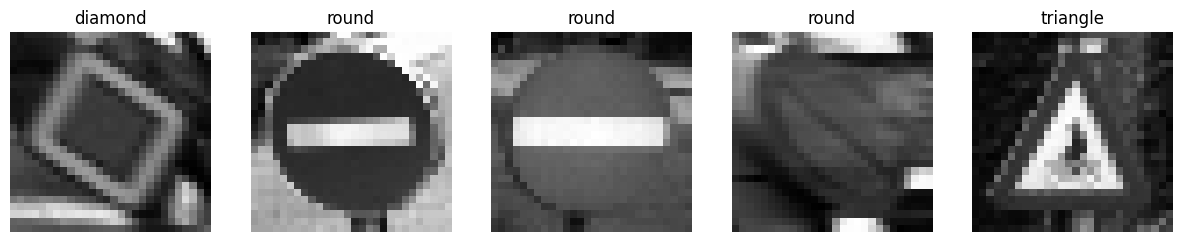

Samples from Type DataFrame:


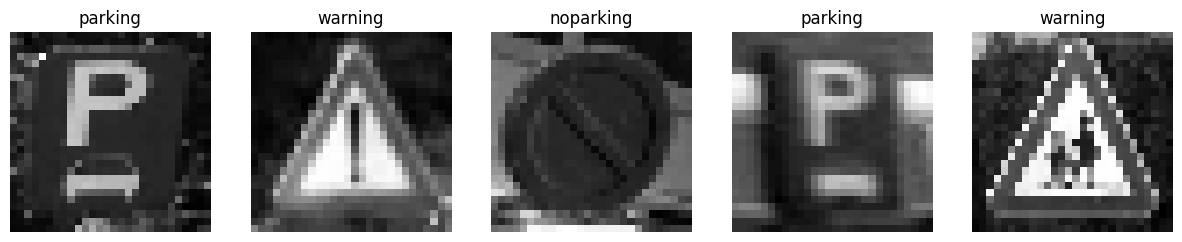

In [11]:
import matplotlib.pyplot as plt
def plot_samples(data_df, num_samples=5):
    """
    Function to plot sample images from a DataFrame along with their labels.

    Args:
    - data_df (DataFrame): DataFrame containing image data and labels.
    - num_samples (int): Number of samples to plot.

    Returns:
    - None
    """

    fig, axes = plt.subplots(1, num_samples, figsize=(15, 3))

    for i in range(num_samples):
        sample = data_df.sample()  # Sampling from the DataFrame passed as input
        image = sample['image'].values[0]  # Assuming 'image' contains the image data
        label = sample['shape_label'].values[0] if 'shape_label' in data_df.columns else sample['type_label'].values[0]
        axes[i].imshow(image, cmap='gray')  # Assuming grayscale images
        axes[i].set_title(label)
        axes[i].axis('off')

    plt.show()


# Plot sample images from the shape DataFrame
print("Samples from Shape DataFrame:")
plot_samples(shape_df)

# Plot sample images from the type DataFrame
print("Samples from Type DataFrame:")
plot_samples(type_df)


In [12]:
from sklearn.preprocessing import LabelEncoder

# Create LabelEncoder instance
label_encoder = LabelEncoder()

# Fit and transform the shape labels
shape_labels_encoded = label_encoder.fit_transform(shape_df['shape_label'])

# Add the encoded labels as a new column in shape_df
shape_df['encoded_shape_label'] = shape_labels_encoded

# Display the updated shape_df
shape_df.head()

,image_path,image,shape_label,encoded_shape_label
0,/content/drive/My Drive/Assignment2/trafficsig...,"[[60, 64, 47, 39, 46, 33, 30, 33, 19, 24, 15, ...",square,3
1,/content/drive/My Drive/Assignment2/trafficsig...,"[[73, 63, 59, 55, 46, 51, 52, 52, 61, 56, 57, ...",square,3
2,/content/drive/My Drive/Assignment2/trafficsig...,"[[255, 255, 255, 255, 255, 254, 254, 254, 255,...",square,3
3,/content/drive/My Drive/Assignment2/trafficsig...,"[[37, 31, 30, 31, 30, 42, 37, 36, 35, 37, 35, ...",square,3
4,/content/drive/My Drive/Assignment2/trafficsig...,"[[117, 88, 77, 96, 87, 72, 79, 91, 80, 78, 76,...",square,3


In [13]:
from sklearn.preprocessing import LabelEncoder

# Create LabelEncoder instance
label_encoder = LabelEncoder()

# Fit and transform the type labels
type_labels_encoded = label_encoder.fit_transform(type_df['type_label'])

# Add the encoded labels as a new column in type_df
type_df['encoded_type_label'] = type_labels_encoded

# Display the updated type_df
type_df.head()

,image_path,image,type_label,encoded_type_label
0,/content/drive/My Drive/Assignment2/trafficsig...,"[[60, 64, 47, 39, 46, 33, 30, 33, 19, 24, 15, ...",crossing,2
1,/content/drive/My Drive/Assignment2/trafficsig...,"[[73, 63, 59, 55, 46, 51, 52, 52, 61, 56, 57, ...",crossing,2
2,/content/drive/My Drive/Assignment2/trafficsig...,"[[255, 255, 255, 255, 255, 254, 254, 254, 255,...",crossing,2
3,/content/drive/My Drive/Assignment2/trafficsig...,"[[37, 31, 30, 31, 30, 42, 37, 36, 35, 37, 35, ...",crossing,2
4,/content/drive/My Drive/Assignment2/trafficsig...,"[[117, 88, 77, 96, 87, 72, 79, 91, 80, 78, 76,...",crossing,2


In [14]:
print("Unique shapes:", shape_df['shape_label'].unique())
print("numbers of shape:", len(shape_df['shape_label'].unique()))
numbers_of_shape = len(shape_df['shape_label'].unique())

Unique shapes: ['square' 'triangle' 'hex' 'round' 'diamond']
numbers of shape: 5


In [15]:
print("Unique shapes:", type_df['type_label'].unique())
print("numbers of shape:", len(type_df['type_label'].unique()))

Unique shapes: ['crossing' 'laneend' 'parking' 'continue' 'giveway' 'warning' 'stop'
 'limitedtraffic' 'noparking' 'speed' 'noentry' 'trafficdirective'
 'roundabout' 'bicycle' 'traveldirection' 'rightofway']
numbers of shape: 16


## **1.4 Data Distribution**


### **1.4.1 Distribution of images per type class**

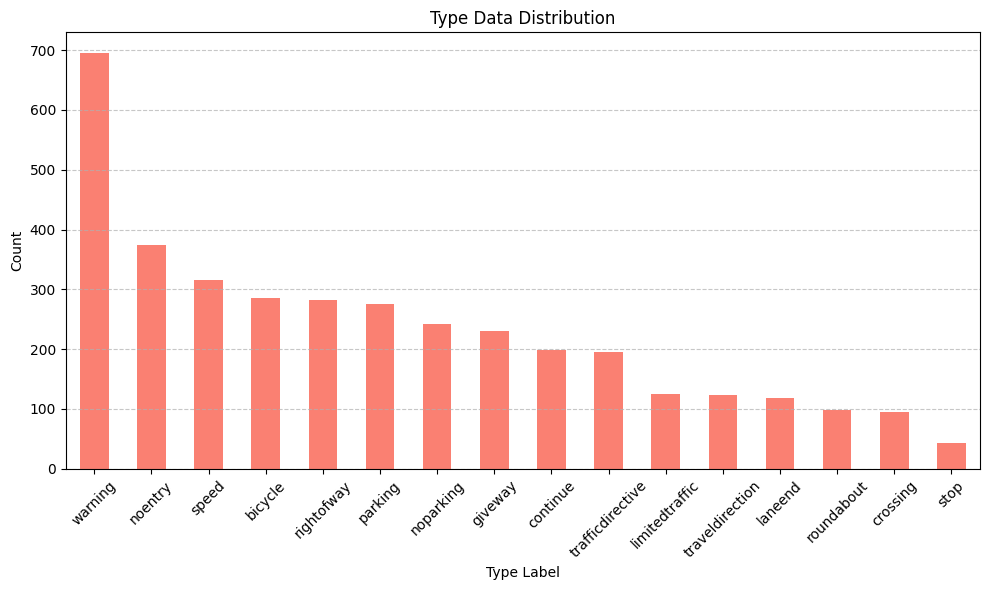

In [16]:
def visualize_data_distribution(data_df, title):
    """
    Function to visualize the distribution of data.

    Args:
    - data_df (DataFrame): Pandas DataFrame containing the data.
    - title (str): Title for the plot.
    """
    plt.figure(figsize=(10, 6))
    data_counts = data_df['type_label'].value_counts()
    data_counts.plot(kind='bar', color='salmon')
    plt.title(title)
    plt.xlabel('Type Label')
    plt.ylabel('Count')
    plt.xticks(rotation=45)
    plt.grid(axis='y', linestyle='--', alpha=0.7)
    plt.tight_layout()
    plt.show()

# Visualize data distribution for type DataFrame
visualize_data_distribution(type_df, 'Type Data Distribution')


**Observations:**
- The distribution of images per class is imbalanced, but not as severe as the class distribution for type.
- This imbalance could potentially affect the performance of a machine-learning model trained on this data, but to a lesser extent than the type data.

### **1.4.2 Distribution of images per shape class**

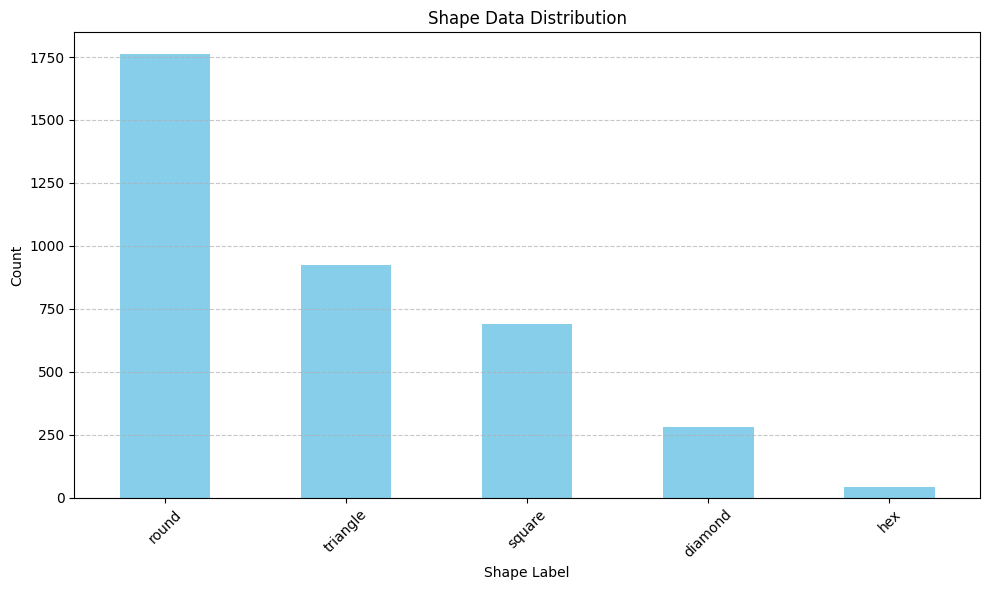

In [17]:
import matplotlib.pyplot as plt

def visualize_data_distribution(data_df, title):
    """
    Function to visualize the distribution of data.

    Args:
    - data_df (DataFrame): Pandas DataFrame containing the data.
    - title (str): Title for the plot.
    """
    plt.figure(figsize=(10, 6))
    data_counts = data_df['shape_label'].value_counts()
    data_counts.plot(kind='bar', color='skyblue')
    plt.title(title)
    plt.xlabel('Shape Label')
    plt.ylabel('Count')
    plt.xticks(rotation=45)
    plt.grid(axis='y', linestyle='--', alpha=0.7)
    plt.tight_layout()
    plt.show()

# Visualize data distribution for shape DataFrame
visualize_data_distribution(shape_df, 'Shape Data Distribution')


**Observations:**
- The distribution of images per class is highly imbalanced.
- This imbalance could potentially affect the performance of a machine-learning model trained on this data.

==========================================================================================================



# **2 Data Preparation**


## **2.1 Data spliting:  Train, Val and Test**

In [18]:
from sklearn.model_selection import train_test_split
import numpy as np
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Rescaling and Formatting the Images
datagen_shape = ImageDataGenerator(rescale=1./255, data_format='channels_last')

# Initialize lists to store training, validation, and testing data for shape and type data
X_shape_train = []
X_shape_val = []
X_shape_test = []
y_shape_train = []
y_shape_val = []
y_shape_test = []

X_type_train = []
X_type_val = []
X_type_test = []
y_type_train = []
y_type_val = []
y_type_test = []

# Split data into groups based on shape labels
shape_groups = shape_df.groupby('shape_label')

# Split data into groups based on type labels
type_groups = type_df.groupby('type_label')

# Split each shape group into training, validation, and testing sets
for label, group in shape_groups:
    print(f"\nShape group label: {label}, Shape: {group.shape[0]}")
    X_train, X_temp, y_train, y_temp = train_test_split(group['image_path'], group['encoded_shape_label'], test_size=0.2, stratify=group['shape_label'])
    X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.25, stratify=y_temp)
    X_shape_train.extend(X_train)
    X_shape_val.extend(X_val)
    X_shape_test.extend(X_test)
    y_shape_train.extend(y_train)
    y_shape_val.extend(y_val)
    y_shape_test.extend(y_test)
    print(f"Train sample size: {len(X_train)}, Validation sample size: {len(X_val)}, Test sample size: {len(X_test)}")

# Split each type group into training, validation, and testing sets
for label, group in type_groups:
    print(f"\nType group label: {label}, Shape: {group.shape[0]}")
    X_train, X_temp, y_train, y_temp = train_test_split(group['image_path'], group['encoded_type_label'], test_size=0.2, stratify=group['type_label'])
    X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.25, stratify=y_temp)
    X_type_train.extend(X_train)
    X_type_val.extend(X_val)
    X_type_test.extend(X_test)
    y_type_train.extend(y_train)
    y_type_val.extend(y_val)
    y_type_test.extend(y_test)
    print(f"Train sample size: {len(X_train)}, Validation sample size: {len(X_val)}, Test sample size: {len(X_test)}")

# Convert to numpy arrays for shape data
X_shape_train = np.array(X_shape_train)
X_shape_val = np.array(X_shape_val)
X_shape_test = np.array(X_shape_test)
y_shape_train = np.array(y_shape_train)
y_shape_val = np.array(y_shape_val)
y_shape_test = np.array(y_shape_test)

# Convert to numpy arrays for type data
X_type_train = np.array(X_type_train)
X_type_val = np.array(X_type_val)
X_type_test = np.array(X_type_test)
y_type_train = np.array(y_type_train)
y_type_val = np.array(y_type_val)
y_type_test = np.array(y_type_test)

# Print shapes of the data sets after splitting for shape data
print("\nShape of X_shape_train:", X_shape_train.shape)
print("Shape of X_shape_val:", X_shape_val.shape)
print("Shape of X_shape_test:", X_shape_test.shape)
print("Shape of y_shape_train:", y_shape_train.shape)
print("Shape of y_shape_val:", y_shape_val.shape)
print("Shape of y_shape_test:", y_shape_test.shape)

# Print shapes of the data sets after splitting for type data
print("\nShape of X_type_train:", X_type_train.shape)
print("Shape of X_type_val:", X_type_val.shape)
print("Shape of X_type_test:", X_type_test.shape)
print("Shape of y_type_train:", y_type_train.shape)
print("Shape of y_type_val:", y_type_val.shape)
print("Shape of y_type_test:", y_type_test.shape)



Shape group label: diamond, Shape: 282
Train sample size: 225, Validation sample size: 42, Test sample size: 15

Shape group label: hex, Shape: 43
Train sample size: 34, Validation sample size: 6, Test sample size: 3

Shape group label: round, Shape: 1760
Train sample size: 1408, Validation sample size: 264, Test sample size: 88

Shape group label: square, Shape: 688
Train sample size: 550, Validation sample size: 103, Test sample size: 35

Shape group label: triangle, Shape: 926
Train sample size: 740, Validation sample size: 139, Test sample size: 47

Type group label: bicycle, Shape: 285
Train sample size: 228, Validation sample size: 42, Test sample size: 15

Type group label: continue, Shape: 199
Train sample size: 159, Validation sample size: 30, Test sample size: 10

Type group label: crossing, Shape: 95
Train sample size: 76, Validation sample size: 14, Test sample size: 5

Type group label: giveway, Shape: 231
Train sample size: 184, Validation sample size: 35, Test sample si

In [ ]:
from sklearn.model_selection import train_test_split

# Split data into train and test sets for shape data
X_shape_train, X_shape_test, y_shape_train, y_shape_test = train_test_split(
    shape_df['image_path'], shape_df['encoded_shape_label'], test_size=0.2, stratify=shape_df['encoded_shape_label'])

# Split train set into train and validation sets for shape data
X_shape_train, X_shape_val, y_shape_train, y_shape_val = train_test_split(
    X_shape_train, y_shape_train, test_size=0.25, stratify=y_shape_train)

# Split data into train and test sets for type data
X_type_train, X_type_test, y_type_train, y_type_test = train_test_split(
    type_df['image_path'], type_df['encoded_type_label'], test_size=0.2, stratify=type_df['encoded_type_label'])

# Split train set into train and validation sets for type data
X_type_train, X_type_val, y_type_train, y_type_val = train_test_split(
    X_type_train, y_type_train, test_size=0.25, stratify=y_type_train)

## **2.2 Flatten the images**

In [19]:
# import numpy as np
# # from keras.preprocessing.image import ImageDataGenerator
# from PIL import Image

# # Function to flatten images
# def flatten_images(X):
#     flattened_images = []
#     for image_path in X:
#         image = Image.open(image_path)
#         image = np.array(image)
#         flattened_image = image.flatten()
#         flattened_images.append(flattened_image)
#     return np.array(flattened_images)

# # Flatten the images for shape data in training and testing sets
# X_shape_train_flat = flatten_images(X_shape_train)
# X_shape_test_flat = flatten_images(X_shape_test)
# X_shape_val_flat = flatten_images(X_shape_val)

# # Flatten the images for type data in training and testing sets
# X_type_train_flat = flatten_images(X_type_train)
# X_type_val_flat = flatten_images(X_type_val)
# X_type_test_flat = flatten_images(X_type_test)

# # Print shapes of the flattened data sets
# print("\nShape of X_shape_train_flat:", X_shape_train_flat.shape)
# print("Shape of X_shape_val_flat:", X_shape_val_flat.shape)
# print("Shape of X_shape_test_flat:", X_shape_test_flat.shape)


# print("\nShape of X_type_train_flat:", X_type_train_flat.shape)
# print("Shape of X_type_val_flat:", X_type_val_flat.shape)
# print("Shape of X_type_test_flat:", X_type_test_flat.shape)

=================================================================================================

# **3. Models development**

In [20]:
import matplotlib.pyplot as plt
def plot_learning_curve(train_loss, val_loss, train_metric, val_metric, metric_name='Accuracy'):
    plt.figure(figsize=(10,5))

    plt.subplot(1,2,1)
    plt.plot(train_loss, 'r--')
    plt.plot(val_loss, 'b--')
    plt.xlabel("epochs")
    plt.ylabel("Loss")
    plt.legend(['train', 'val'], loc='upper left')

    plt.subplot(1,2,2)
    plt.plot(train_metric, 'r--')
    plt.plot(val_metric, 'b--')
    plt.xlabel("epochs")
    plt.ylabel(metric_name)
    plt.legend(['train', 'val'], loc='upper left')

    plt.show()

In [21]:
# install tensorflow library
import tensorflow as tf

# optimise data pipeline performance automatically
AUTOTUNE = tf.data.experimental.AUTOTUNE

# print the version of TensorFlow
tf.__version__

'2.15.0'

## **3.1 Baseline Model**

### **3.1.1.1 Image generator for shape**

In [22]:
df_X_shape_train = pd.DataFrame({'image_path': X_shape_train,'encoded_shape_label': y_shape_train})
df_X_shape_val = pd.DataFrame({'image_path': X_shape_val,'encoded_shape_label': y_shape_val})


df_X_shape_train['encoded_shape_label'] = df_X_shape_train['encoded_shape_label'].astype(str)
df_X_shape_val['encoded_shape_label'] = df_X_shape_val['encoded_shape_label'].astype(str)


df_X_shape_test = pd.DataFrame({'image_path': X_shape_test,'encoded_shape_label': y_shape_test})
df_X_shape_test['encoded_shape_label'] = df_X_shape_test['encoded_shape_label'].astype(str)

In [23]:

# Defining image data generators
datagen_shape = ImageDataGenerator(rescale=1./255, data_format='channels_last')

# Create training data generator
train_generator_shape = datagen_shape.flow_from_dataframe(
    dataframe=df_X_shape_train,
    directory='./',
    x_col="image_path",
    y_col="encoded_shape_label",
    target_size=(28, 28),
    color_mode='grayscale',
    batch_size=32,
    class_mode='categorical')



# Create validation data generator
validation_generator_shape = datagen_shape.flow_from_dataframe(
    dataframe=df_X_shape_val,
    directory='./',
    x_col="image_path",
    y_col="encoded_shape_label",
    target_size=(28, 28),
    color_mode='grayscale',
    batch_size=32,
    class_mode='categorical')




Found 2957 validated image filenames belonging to 5 classes.
Found 554 validated image filenames belonging to 5 classes.


In [24]:
from sklearn.metrics import classification_report, f1_score,confusion_matrix


def model_result(X_train, X_val, model):
  y_hat_all = list()
  y_all = list()
  y_pred_all = []
  y_true_all = []
  filenames = validation_generator_shape.filenames
  N_images = len(filenames)
  batches = 0

  # iterate through the data generator and predict for each batch
  # hold the predictions and labels
  for x,y in X_val:
          y_hat = model.predict(x, verbose=0)
          y_hat = np.argmax(y_hat, axis = 1)
          y = np.argmax(y, axis = 1)
          y_hat_all = y_hat_all + y_hat.tolist()
          y_all = y_all + y.tolist()

          batches += 1
          if batches >= N_images / batch_size:
              # we need to break the loop by hand because
              # the generator loops indefinitely
              break

  for a,b in X_train:
          y_pred = model.predict(a, verbose=0)
          y_pred = np.argmax(y_pred, axis = 1)
          y_true = np.argmax(b, axis = 1)
          y_pred_all = y_pred_all + y_pred.tolist()
          y_true_all = y_true_all + y_true.tolist()

          batches += 1
          if batches >= N_images / batch_size:
              # we need to break the loop by hand because
              # the generator loops indefinitely
              break

  # now you have made the predictions you can use any performance metric
  # you wish: either in sklearn or some function you have written

  print("Training F1- score: ", f1_score(y_true_all, y_pred_all,average='macro'))
  print("F1 score: ", f1_score(y_all, y_hat_all, average='macro'))

### **3.1.1.2 Building baseline model using A Multi-Layer Perceptron (MLP) for image shape**

In [25]:
INPUT_DIM = (28, 28, 1)
HIDDEN_LAYER_DIM = 256
SECOND_HIDDEN_LAYER_DIM = 128  # Size of the second hidden layer
OUTPUT_CLASSES_SHAPE = 5

In [26]:
test_datagen = ImageDataGenerator(rescale=1./255, data_format='channels_last')

batch_size = 1

test_generator_shape = test_datagen.flow_from_dataframe(
    dataframe=df_X_shape_test,
    directory='./',
    x_col="image_path",
    y_col="encoded_shape_label",
    target_size=(28, 28),
    color_mode='grayscale',
    batch_size=32,
    class_mode='categorical')

Found 188 validated image filenames belonging to 5 classes.


In [27]:
# Build the baseline model with an additional hidden layer
model_mlp_shape = tf.keras.Sequential([
    tf.keras.layers.Flatten(input_shape=INPUT_DIM),
    tf.keras.layers.Dense(HIDDEN_LAYER_DIM, activation='sigmoid'),
    tf.keras.layers.Dense(SECOND_HIDDEN_LAYER_DIM, activation='sigmoid'),  # Additional hidden layer
    tf.keras.layers.Dense(OUTPUT_CLASSES_SHAPE)
])

In [28]:
model_mlp_shape.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten (Flatten)           (None, 784)               0         
                                                                 
 dense (Dense)               (None, 256)               200960    
                                                                 
 dense_1 (Dense)             (None, 128)               32896     
                                                                 
 dense_2 (Dense)             (None, 5)                 645       
                                                                 
Total params: 234501 (916.02 KB)
Trainable params: 234501 (916.02 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [29]:
model_mlp_shape.compile(
    optimizer='SGD',
    loss=tf.keras.losses.CategoricalCrossentropy(from_logits=True),
    metrics=['categorical_accuracy']
)

In [30]:
history_mlp_shape = model_mlp_shape.fit(train_generator_shape, validation_data=validation_generator_shape, epochs=10, verbose=0)


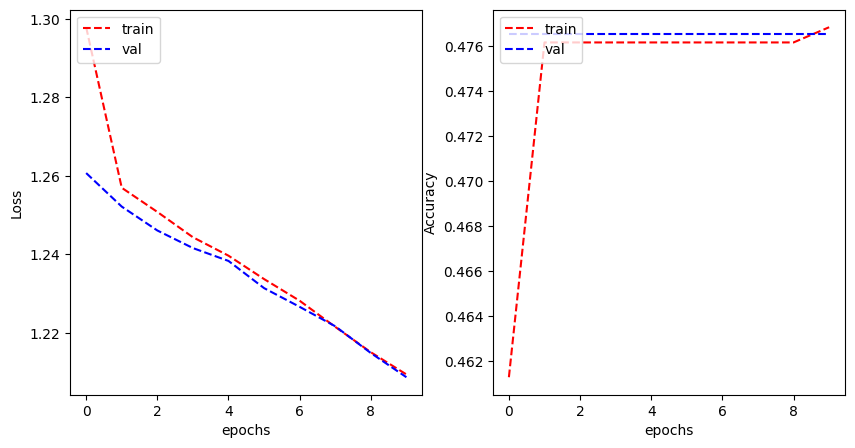

In [31]:
plot_learning_curve(history_mlp_shape.history['loss'], history_mlp_shape.history['val_loss'],
                    history_mlp_shape.history['categorical_accuracy'], history_mlp_shape.history['val_categorical_accuracy'],
                    metric_name='Accuracy')

### **3.1.1.3 Evaluate the model**

In [32]:
 # Evaluate the model on the training data
train_loss_mlp_shape, train_accuracy_mlp_shape = model_mlp_shape.evaluate(train_generator_shape)
print("Training Data for Shapes - Loss: {:.4f}, Accuracy: {:.4f}".format(train_loss_mlp_shape, train_accuracy_mlp_shape))

# Evaluate the model on the validation data
val_loss_mlp_shape, val_accuracy_mlp_shape = model_mlp_shape.evaluate(validation_generator_shape)
print("Validation Data for Shapes - Loss: {:.4f}, Accuracy: {:.4f}".format(val_loss_mlp_shape, val_accuracy_mlp_shape))

# Evaluate the model on the testing data
test_loss_mlp_shape, test_accuracy_mlp_shape = model_mlp_shape.evaluate(test_generator_shape)
print("Testing Data for Shapes - Loss: {:.4f}, Accuracy: {:.4f}".format(test_loss_mlp_shape, test_accuracy_mlp_shape))


93/93 [==============================] - 13s 137ms/step - loss: 1.2028 - categorical_accuracy: 0.4762
Training Data for Shapes - Loss: 1.2028, Accuracy: 0.4762
18/18 [==============================] - 3s 145ms/step - loss: 1.2087 - categorical_accuracy: 0.4765
Validation Data for Shapes - Loss: 1.2087, Accuracy: 0.4765
6/6 [==============================] - 1s 131ms/step - loss: 1.2269 - categorical_accuracy: 0.4681
Testing Data for Shapes - Loss: 1.2269, Accuracy: 0.4681


### **3.1.2.1 Image generator for Type**

In [33]:
df_X_type_train = pd.DataFrame({'image_path': X_type_train,'encoded_type_label': y_type_train})
df_X_type_val = pd.DataFrame({'image_path': X_type_val,'encoded_type_label': y_type_val})


df_X_type_train['encoded_type_label'] = df_X_type_train['encoded_type_label'].astype(str)
df_X_type_val['encoded_type_label'] = df_X_type_val['encoded_type_label'].astype(str)


df_X_type_test = pd.DataFrame({'image_path': X_type_test,'encoded_type_label': y_type_test})
df_X_type_test['encoded_type_label'] = df_X_type_test['encoded_type_label'].astype(str)

In [34]:
# Defining image data generators
datagen_type = ImageDataGenerator(rescale=1./255, data_format='channels_last')

# Create training data generator
train_generator_type = datagen_type.flow_from_dataframe(
    dataframe=df_X_type_train,
    directory='./',
    x_col="image_path",
    y_col="encoded_type_label",
    target_size=(28, 28),
    color_mode='grayscale',
    batch_size=32,
    class_mode='categorical')



# Create validation data generator
validation_generator_type = datagen_type.flow_from_dataframe(
    dataframe=df_X_type_val,
    directory='./',
    x_col="image_path",
    y_col="encoded_type_label",
    target_size=(28, 28),
    color_mode='grayscale',
    batch_size=32,
    class_mode='categorical')

Found 2954 validated image filenames belonging to 16 classes.
Found 553 validated image filenames belonging to 16 classes.


### **3.1.2 Building baseline model using A Multi-Layer Perceptron (MLP) for image type**

In [35]:
import tensorflow as tf

INPUT_DIM = (28, 28, 1)
HIDDEN_LAYER_DIM = 256
SECOND_HIDDEN_LAYER_DIM = 128  # Size of the second hidden layer
OUTPUT_CLASSES_TYPE = 16

In [36]:
test_datagen = ImageDataGenerator(rescale=1./255, data_format='channels_last')

batch_size = 1

test_generator_type = test_datagen.flow_from_dataframe(
    dataframe=df_X_type_test,
    directory='./',
    x_col="image_path",
    y_col="encoded_type_label",
    target_size=(28, 28),
    color_mode='grayscale',
    batch_size=32,
    class_mode='categorical')

Found 192 validated image filenames belonging to 16 classes.


In [37]:
# build the baseline model
model_mlp_type = tf.keras.Sequential([
    tf.keras.layers.Flatten(input_shape=INPUT_DIM),
    tf.keras.layers.Dense(HIDDEN_LAYER_DIM, activation='sigmoid'),
    tf.keras.layers.Dense(SECOND_HIDDEN_LAYER_DIM, activation='sigmoid'),
    tf.keras.layers.Dense(OUTPUT_CLASSES_TYPE)
])

In [38]:
model_mlp_type.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten_1 (Flatten)         (None, 784)               0         
                                                                 
 dense_3 (Dense)             (None, 256)               200960    
                                                                 
 dense_4 (Dense)             (None, 128)               32896     
                                                                 
 dense_5 (Dense)             (None, 16)                2064      
                                                                 
Total params: 235920 (921.56 KB)
Trainable params: 235920 (921.56 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [39]:
model_mlp_type.compile(optimizer='SGD',
              loss=tf.keras.losses.CategoricalCrossentropy(from_logits=True),
              metrics=['categorical_accuracy'])

In [40]:
history_mlp_type = model_mlp_type.fit(train_generator_type, validation_data=validation_generator_type, epochs=10, verbose=1)


Epoch 1/10
93/93 [==============================] - 16s 172ms/step - loss: 2.6617 - categorical_accuracy: 0.1669 - val_loss: 2.5851 - val_categorical_accuracy: 0.1881
Epoch 2/10
93/93 [==============================] - 16s 170ms/step - loss: 2.5828 - categorical_accuracy: 0.1882 - val_loss: 2.5705 - val_categorical_accuracy: 0.1881
Epoch 3/10
93/93 [==============================] - 15s 166ms/step - loss: 2.5723 - categorical_accuracy: 0.1882 - val_loss: 2.5637 - val_categorical_accuracy: 0.1881
Epoch 4/10
93/93 [==============================] - 15s 162ms/step - loss: 2.5655 - categorical_accuracy: 0.1882 - val_loss: 2.5566 - val_categorical_accuracy: 0.1881
Epoch 5/10
93/93 [==============================] - 15s 163ms/step - loss: 2.5585 - categorical_accuracy: 0.1882 - val_loss: 2.5510 - val_categorical_accuracy: 0.1881
Epoch 6/10
93/93 [==============================] - 15s 167ms/step - loss: 2.5517 - categorical_accuracy: 0.1882 - val_loss: 2.5432 - val_categorical_accuracy: 0.188

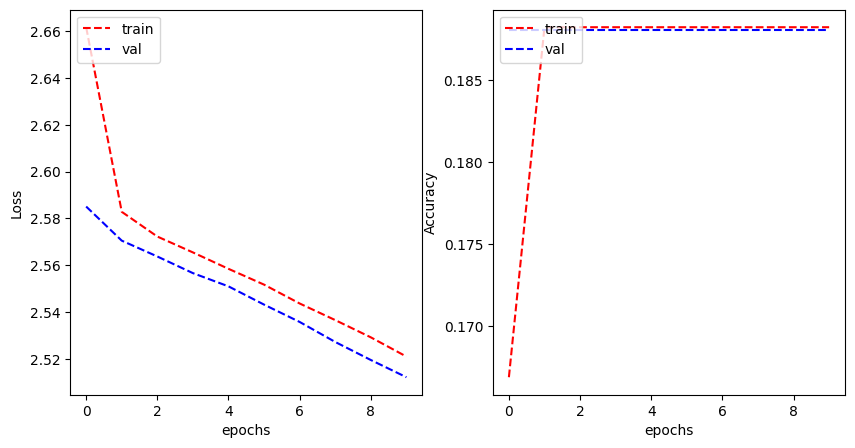

In [41]:
plot_learning_curve(history_mlp_type.history['loss'], history_mlp_type.history['val_loss'],
                    history_mlp_type.history['categorical_accuracy'], history_mlp_type.history['val_categorical_accuracy'],
                    metric_name='Accuracy')

### **3.1.1.3 Evaluate the model**

In [42]:
# Evaluate the model on the training data
train_loss_mlp_type, train_accuracy_mlp_type = model_mlp_type.evaluate(train_generator_type)
print("Training Data for Types - Loss: {:.4f}, Accuracy: {:.4f}".format(train_loss_mlp_type, train_accuracy_mlp_type))

# Evaluate the model on the validation data
val_loss_mlp_type, val_accuracy_mlp_type = model_mlp_type.evaluate(validation_generator_type)
print("Validation Data for Types - Loss: {:.4f}, Accuracy: {:.4f}".format(val_loss_mlp_type, val_accuracy_mlp_type))

# Evaluate the model on the testing data
test_loss_mlp_type, test_accuracy_mlp_type = model_mlp_type.evaluate(test_generator_type)
print("Testing Data for Types - Loss: {:.4f}, Accuracy: {:.4f}".format(test_loss_mlp_type, test_accuracy_mlp_type))


93/93 [==============================] - 12s 133ms/step - loss: 2.5133 - categorical_accuracy: 0.1882
Training Data for Types - Loss: 2.5133, Accuracy: 0.1882
18/18 [==============================] - 2s 125ms/step - loss: 2.5122 - categorical_accuracy: 0.1881
Validation Data for Types - Loss: 2.5122, Accuracy: 0.1881
6/6 [==============================] - 1s 128ms/step - loss: 2.5317 - categorical_accuracy: 0.1823
Testing Data for Types - Loss: 2.5317, Accuracy: 0.1823



**Observations:**

1. **Baseline Model for Shape Classification:**
    - The baseline MLP model for shape classification achieved a training accuracy of {train_accuracy_mlp_shape:.4f} and a validation accuracy of {val_accuracy_mlp_shape:.4f}.
    - The testing accuracy on unseen data was {test_accuracy_mlp_shape:.4f}.

2. **Baseline Model for Type Classification:**
    - The baseline MLP model for type classification achieved a training accuracy of {train_accuracy_mlp_type:.4f} and a validation accuracy of {val_accuracy_mlp_type:.4f}.
    - The testing accuracy on unseen data was {test_accuracy_mlp_type:.4f}.

3. **Overall:**
    - Both baseline models exhibited moderate performance on the imbalanced datasets.
    - The relatively low accuracy scores indicate the need for further model optimization and potential exploration of alternative approaches.
    - The performance difference between training and testing accuracy suggests the potential for overfitting, which should be addressed in future model iterations.

    

=====================================================================================================

# **3.2 Building baseline model using  Visual Geometry Group (VGG1_shape)**

In [43]:
model_VGG1_shape = tf.keras.Sequential([
    #VGG block 1
    tf.keras.layers.Conv2D(32, (3, 3), activation='relu', padding='same', input_shape=(28, 28, 1)),
    tf.keras.layers.Conv2D(32, (3, 3), activation='relu', padding='same'),
    tf.keras.layers.MaxPooling2D((2, 2)),

    #VGG block 2
    tf.keras.layers.Conv2D(64, (3, 3), activation='relu', padding='same'),
    tf.keras.layers.Conv2D(64, (3, 3), activation='relu', padding='same'),
    tf.keras.layers.MaxPooling2D((2, 2)),

    #VGG block 3
    tf.keras.layers.Conv2D(128, (3, 3), activation='relu', padding='same'),
    tf.keras.layers.Conv2D(128, (3, 3), activation='relu', padding='same'),
    tf.keras.layers.MaxPooling2D((2, 2)),

    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(128, activation='relu'),
    tf.keras.layers.Dense(OUTPUT_CLASSES_SHAPE),
])

In [44]:
model_VGG1_shape.compile(optimizer='SGD',
              loss=tf.keras.losses.CategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [45]:
history_VGG1_shape = model_VGG1_shape.fit(train_generator_shape, validation_data = validation_generator_shape, epochs=10, verbose=1)

Epoch 1/10
93/93 [==============================] - 31s 319ms/step - loss: 1.3724 - accuracy: 0.4745 - val_loss: 1.2626 - val_accuracy: 0.4765
Epoch 2/10
93/93 [==============================] - 29s 316ms/step - loss: 1.2380 - accuracy: 0.4822 - val_loss: 1.2145 - val_accuracy: 0.4819
Epoch 3/10
93/93 [==============================] - 30s 320ms/step - loss: 1.1919 - accuracy: 0.5103 - val_loss: 1.1833 - val_accuracy: 0.5361
Epoch 4/10
93/93 [==============================] - 29s 315ms/step - loss: 1.1112 - accuracy: 0.5742 - val_loss: 1.1078 - val_accuracy: 0.5560
Epoch 5/10
93/93 [==============================] - 29s 316ms/step - loss: 0.9604 - accuracy: 0.6469 - val_loss: 0.8445 - val_accuracy: 0.7509
Epoch 6/10
93/93 [==============================] - 29s 312ms/step - loss: 0.7694 - accuracy: 0.7464 - val_loss: 0.6449 - val_accuracy: 0.8105
Epoch 7/10
93/93 [==============================] - 26s 283ms/step - loss: 0.5714 - accuracy: 0.8123 - val_loss: 0.4879 - val_accuracy: 0.8592

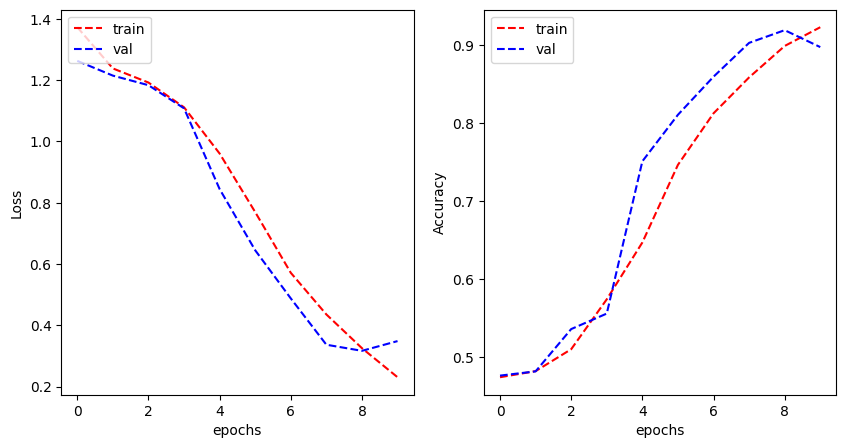

In [46]:
plot_learning_curve(history_VGG1_shape.history['loss'], history_VGG1_shape.history['val_loss'],
                 history_VGG1_shape .history['accuracy'], history_VGG1_shape.history['val_accuracy'],
                    metric_name='Accuracy')

In [47]:
# Evaluate the model on the training data
train_loss_VGG1_shape, train_accuracy_VGG1_shape = model_VGG1_shape.evaluate(train_generator_shape)
print("Training Data for Shapes - Loss: {:.4f}, Accuracy: {:.4f}".format(train_loss_VGG1_shape, train_accuracy_VGG1_shape))

# Evaluate the model on the validation data
val_loss_VGG1_shape, val_accuracy_VGG1_shape = model_VGG1_shape.evaluate(validation_generator_shape)
print("Validation Data for Shapes - Loss: {:.4f}, Accuracy: {:.4f}".format(val_loss_VGG1_shape, val_accuracy_VGG1_shape))

# Evaluate the model on the testing data
test_loss_VGG1_shape, test_accuracy_VGG1_shape = model_VGG1_shape.evaluate(test_generator_shape)
print("Testing Data for Shapes - Loss: {:.4f}, Accuracy: {:.4f}".format(test_loss_VGG1_shape, test_accuracy_VGG1_shape))


93/93 [==============================] - 15s 161ms/step - loss: 0.2611 - accuracy: 0.9107
Training Data for Shapes - Loss: 0.2611, Accuracy: 0.9107
18/18 [==============================] - 3s 175ms/step - loss: 0.3487 - accuracy: 0.8971
Validation Data for Shapes - Loss: 0.3487, Accuracy: 0.8971
6/6 [==============================] - 1s 146ms/step - loss: 0.3168 - accuracy: 0.8883
Testing Data for Shapes - Loss: 0.3168, Accuracy: 0.8883


Improving model

After analyzing the baseline model, it has been observed that the model exhibits signs of overfitting. It occurs when the model performs well on the training data but fails to generalize effectively to unseen data. To prevent overfitting, we can apply some common effective techniques used in machine learning to improve the performance of the model and prevent overfitting. For example:

- 1. Ridge regularisation
- 2. Dropout
- 3. Reduce model complexity
- 4. Data augmentation

More detailed explanation of these techniques will be provided in subsequent sections.

## Approcah 1. Ridge Regularization and Hyperparameter Tuning:

In [48]:
# Parameter tuning of regularization value
from keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, BatchNormalization
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix, accuracy_score, f1_score

# Hyperparameter tuning for Ridge regularization
reg_lambdas = [0.002, 0.004, 0.006, 0.01, 0.1]

# the highest validation accuracy is the best performance
best_performance = 0.0
best_reg_lambda = None
model_test_acc = None
model_train_acc = None

for reg_lambda in reg_lambdas:
    model_VGG2_shape_tuning = tf.keras.Sequential([
        #VGG block 1
        tf.keras.layers.Conv2D(32, (3, 3), activation='relu', padding='same',
                               kernel_regularizer=tf.keras.regularizers.l2(reg_lambda), input_shape=(28, 28, 1)),
        tf.keras.layers.Conv2D(32, (3, 3), activation='relu', padding='same',
                               kernel_regularizer=tf.keras.regularizers.l2(reg_lambda)),
        tf.keras.layers.MaxPooling2D((2, 2)),

        #VGG block 2
        tf.keras.layers.Conv2D(64, (3, 3), activation='relu', padding='same',
                               kernel_regularizer=tf.keras.regularizers.l2(reg_lambda)),
        tf.keras.layers.Conv2D(64, (3, 3), activation='relu', padding='same',
                               kernel_regularizer=tf.keras.regularizers.l2(reg_lambda)),
        tf.keras.layers.MaxPooling2D((2, 2)),

        #VGG block 3
        tf.keras.layers.Conv2D(128, (3, 3), activation='relu', padding='same',
                               kernel_regularizer=tf.keras.regularizers.l2(reg_lambda)),
        tf.keras.layers.Conv2D(128, (3, 3), activation='relu', padding='same',
                               kernel_regularizer=tf.keras.regularizers.l2(reg_lambda)),
        tf.keras.layers.MaxPooling2D((2, 2)),

        # Dense Layers
        tf.keras.layers.Flatten(),
        tf.keras.layers.Dense(128, activation='relu'),
        tf.keras.layers.Dense(OUTPUT_CLASSES_SHAPE),
    ])



In [49]:
# compile the model
model_VGG2_shape_tuning.compile(optimizer='adam', loss=tf.keras.losses.CategoricalCrossentropy(from_logits=True), metrics=['accuracy'])

In [50]:
# fit and train the model
history_VGG2_shape_tuning = model_VGG2_shape_tuning.fit(train_generator_shape, validation_data = validation_generator_shape, epochs=10, verbose=1)

Epoch 1/10
93/93 [==============================] - 33s 339ms/step - loss: 8.4162 - accuracy: 0.4762 - val_loss: 1.4550 - val_accuracy: 0.4765
Epoch 2/10
93/93 [==============================] - 29s 313ms/step - loss: 1.3113 - accuracy: 0.4762 - val_loss: 1.2658 - val_accuracy: 0.4765
Epoch 3/10
93/93 [==============================] - 28s 294ms/step - loss: 1.2653 - accuracy: 0.4762 - val_loss: 1.2616 - val_accuracy: 0.4765
Epoch 4/10
93/93 [==============================] - 29s 314ms/step - loss: 1.2654 - accuracy: 0.4762 - val_loss: 1.2649 - val_accuracy: 0.4765
Epoch 5/10
93/93 [==============================] - 28s 305ms/step - loss: 1.2675 - accuracy: 0.4762 - val_loss: 1.2641 - val_accuracy: 0.4765
Epoch 6/10
93/93 [==============================] - 27s 286ms/step - loss: 1.2645 - accuracy: 0.4762 - val_loss: 1.2638 - val_accuracy: 0.4765
Epoch 7/10
93/93 [==============================] - 27s 287ms/step - loss: 1.2660 - accuracy: 0.4762 - val_loss: 1.2579 - val_accuracy: 0.4765

In [51]:
# evaluate the model performance
train_accuracy_VGG2_shape_tuning = history_VGG2_shape_tuning.history['accuracy'][-1]
train_loss_VGG2_shape_tuning = history_VGG2_shape_tuning.history['loss'][-1]  # Retrieve the last training loss
val_accuracy_VGG2_shape_tuning = history_VGG2_shape_tuning.history['val_accuracy'][-1]
val_loss_VGG2_shape_tuning = history_VGG2_shape_tuning.history['val_loss'][-1]  # Retrieve the last validation loss
test_loss_VGG2_shape_tuning, test_accuracy_VGG2_shape_tuning = model_VGG2_shape_tuning.evaluate(test_generator_shape, verbose=0)

print(f"reg_lambda = {reg_lambda}, train_loss = {train_loss_VGG2_shape_tuning}, train_accuracy = {train_accuracy_VGG2_shape_tuning}, val_loss = {val_loss_VGG2_shape_tuning}, val_accuracy = {val_accuracy_VGG2_shape_tuning}, test_accuracy = {test_accuracy_VGG2_shape_tuning}\n")

# Update the best performance and regularization lambda
if val_accuracy_VGG2_shape_tuning > best_performance:
  best_performance = val_accuracy_VGG2_shape_tuning
  best_reg_lambda = reg_lambda
  model_train_acc = train_accuracy_VGG2_shape_tuning
  model_test_acc = test_accuracy_VGG2_shape_tuning

reg_lambda = 0.1, train_loss = 1.2648271322250366, train_accuracy = 0.4761582612991333, val_loss = 1.2580275535583496, val_accuracy = 0.47653430700302124, test_accuracy = 0.4680851101875305



In [52]:
print(f"Best model performance:")
print(f"Best regularization lambda: {best_reg_lambda} based on validation accuracy: {best_performance} \nwhere train_accuracy: {model_train_acc} and test accuracy: {model_test_acc}")

Best model performance:
Best regularization lambda: 0.1 based on validation accuracy: 0.47653430700302124 
where train_accuracy: 0.4761582612991333 and test accuracy: 0.4680851101875305


In [53]:
# A full model performance evaluation of `model_VGG2` based on test data:
from keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, BatchNormalization
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix, accuracy_score, f1_score

reg_lambda = 0.02

model_VGG2_shape = tf.keras.Sequential([
    #VGG block 1
    tf.keras.layers.Conv2D(32, (3, 3), activation='relu', padding='same',
                           kernel_regularizer=tf.keras.regularizers.l2(reg_lambda), input_shape=(28, 28, 1)),
    tf.keras.layers.Conv2D(32, (3, 3), activation='relu', padding='same',
                           kernel_regularizer=tf.keras.regularizers.l2(reg_lambda)),
    tf.keras.layers.MaxPooling2D((2, 2)),

    #VGG block 2
    tf.keras.layers.Conv2D(64, (3, 3), activation='relu', padding='same',
                           kernel_regularizer=tf.keras.regularizers.l2(reg_lambda)),
    tf.keras.layers.Conv2D(64, (3, 3), activation='relu', padding='same',
                           kernel_regularizer=tf.keras.regularizers.l2(reg_lambda)),
    tf.keras.layers.MaxPooling2D((2, 2)),

    #VGG block 3
    tf.keras.layers.Conv2D(128, (3, 3), activation='relu', padding='same',
                           kernel_regularizer=tf.keras.regularizers.l2(reg_lambda)),
    tf.keras.layers.Conv2D(128, (3, 3), activation='relu', padding='same',
                           kernel_regularizer=tf.keras.regularizers.l2(reg_lambda)),
    tf.keras.layers.MaxPooling2D((2, 2)),

    # Dense Layers
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(128, activation='relu'),
    tf.keras.layers.Dense(OUTPUT_CLASSES_SHAPE),
])

# Train the model and evaluate its performance
model_VGG2_shape.compile(optimizer='adam',
                   loss=tf.keras.losses.CategoricalCrossentropy(from_logits=True),
                   metrics=['accuracy'])


In [54]:
history_VGG2_shape = model_VGG2_shape.fit(train_generator_shape, validation_data = validation_generator_shape, epochs=10, verbose=1)

Epoch 1/10
93/93 [==============================] - 29s 297ms/step - loss: 3.0925 - accuracy: 0.4762 - val_loss: 1.5125 - val_accuracy: 0.4765
Epoch 2/10
93/93 [==============================] - 31s 337ms/step - loss: 1.3956 - accuracy: 0.4762 - val_loss: 1.3253 - val_accuracy: 0.4765
Epoch 3/10
93/93 [==============================] - 29s 314ms/step - loss: 1.3126 - accuracy: 0.4762 - val_loss: 1.2842 - val_accuracy: 0.4765
Epoch 4/10
93/93 [==============================] - 34s 365ms/step - loss: 1.2822 - accuracy: 0.4762 - val_loss: 1.2824 - val_accuracy: 0.4765
Epoch 5/10
93/93 [==============================] - 33s 350ms/step - loss: 1.2721 - accuracy: 0.4762 - val_loss: 1.2645 - val_accuracy: 0.4765
Epoch 6/10
93/93 [==============================] - 34s 369ms/step - loss: 1.2683 - accuracy: 0.4762 - val_loss: 1.2671 - val_accuracy: 0.4765
Epoch 7/10
93/93 [==============================] - 34s 363ms/step - loss: 1.2659 - accuracy: 0.4762 - val_loss: 1.2613 - val_accuracy: 0.4765

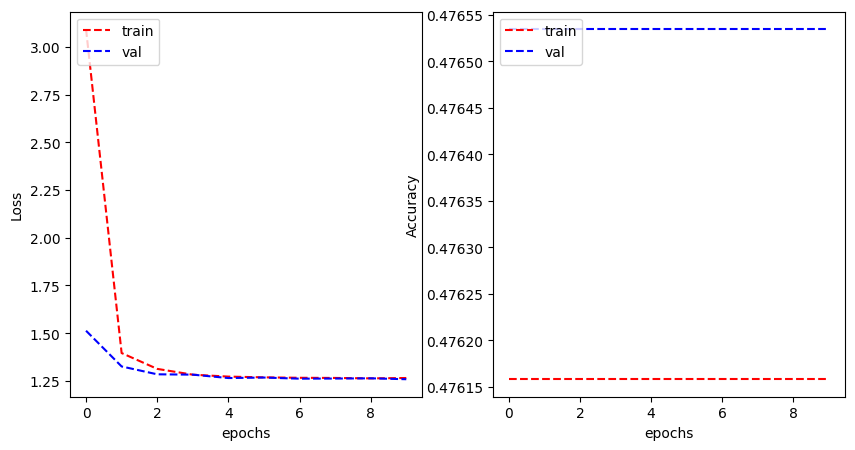

In [55]:
plot_learning_curve(history_VGG2_shape.history['loss'], history_VGG2_shape.history['val_loss'],
                    history_VGG2_shape.history['accuracy'], history_VGG2_shape.history['val_accuracy'],
                    metric_name='Accuracy')

In [56]:
# Evaluate the model on the training data
train_loss_VGG2_shape, train_accuracy_VGG2_shape = model_VGG2_shape.evaluate(train_generator_shape)
print("Training Data for Shapes - Loss: {:.4f}, Accuracy: {:.4f}".format(train_loss_VGG2_shape, train_accuracy_VGG2_shape))

# Evaluate the model on the validation data
val_loss_VGG2_shape, val_accuracy_VGG2_shape = model_VGG2_shape.evaluate(validation_generator_shape)
print("Validation Data for Shapes - Loss: {:.4f}, Accuracy: {:.4f}".format(val_loss_VGG2_shape, val_accuracy_VGG2_shape))

# Evaluate the model on the testing data
test_loss_VGG2_shape, test_accuracy_VGG2_shape = model_VGG2_shape.evaluate(test_generator_shape)
print("Testing Data for Shapes - Loss: {:.4f}, Accuracy: {:.4f}".format(test_loss_VGG2_shape, test_accuracy_VGG2_shape))


93/93 [==============================] - 18s 193ms/step - loss: 1.2610 - accuracy: 0.4762
Training Data for Shapes - Loss: 1.2610, Accuracy: 0.4762
18/18 [==============================] - 3s 170ms/step - loss: 1.2584 - accuracy: 0.4765
Validation Data for Shapes - Loss: 1.2584, Accuracy: 0.4765
6/6 [==============================] - 1s 171ms/step - loss: 1.2836 - accuracy: 0.4681
Testing Data for Shapes - Loss: 1.2836, Accuracy: 0.4681


In [57]:
model_result(train_generator_shape,validation_generator_shape,model_VGG2_shape)

Training F1- score:  0.1595744680851064
F1 score:  0.12907936507936507


### **Dropout and Hyperparameter Tuning**

In [58]:
from keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, BatchNormalization

reg_lambda = 0.02
dropout_rates = [0.2, 0.3, 0.4, 0.5, 0.6]

best_performance = 0.0
best_dropout_rate = None
model_test_acc = None
model_train_acc = None

for dropout_rate in dropout_rates:
    model_VGG3_shape_tuning = tf.keras.Sequential([
        #VGG block 1
        tf.keras.layers.Conv2D(32, (3, 3), activation='relu', padding='same',
                               kernel_regularizer=tf.keras.regularizers.l2(reg_lambda), input_shape=(28, 28, 1)),
        tf.keras.layers.Conv2D(32, (3, 3), activation='relu', padding='same',
                               kernel_regularizer=tf.keras.regularizers.l2(reg_lambda)),
        tf.keras.layers.MaxPooling2D((2, 2)),

        #VGG block 2
        tf.keras.layers.Conv2D(64, (3, 3), activation='relu', padding='same',
                               kernel_regularizer=tf.keras.regularizers.l2(reg_lambda)),
        tf.keras.layers.Conv2D(64, (3, 3), activation='relu', padding='same',
                               kernel_regularizer=tf.keras.regularizers.l2(reg_lambda)),
        tf.keras.layers.MaxPooling2D((2, 2)),

        #VGG block 3
        tf.keras.layers.Conv2D(128, (3, 3), activation='relu', padding='same',
                               kernel_regularizer=tf.keras.regularizers.l2(reg_lambda)),
        tf.keras.layers.Conv2D(128, (3, 3), activation='relu', padding='same',
                               kernel_regularizer=tf.keras.regularizers.l2(reg_lambda)),
        tf.keras.layers.MaxPooling2D((2, 2)),

        # Dense Layers
        tf.keras.layers.Flatten(),
        tf.keras.layers.Dense(128, activation='relu'),
        tf.keras.layers.Dropout(dropout_rate),
        tf.keras.layers.Dense(OUTPUT_CLASSES_SHAPE),
    ])

        # Train the model and evaluate its performance
    model_VGG3_shape_tuning.compile(optimizer='adam',
                       loss=tf.keras.losses.CategoricalCrossentropy(from_logits=True),
                       metrics=['accuracy'])

    history_VGG3_shape_tuning = model_VGG3_shape_tuning.fit(train_generator_shape, validation_data = validation_generator_shape, epochs=8, verbose=1)

Epoch 1/8
93/93 [==============================] - 35s 351ms/step - loss: 2.9727 - accuracy: 0.4691 - val_loss: 1.4253 - val_accuracy: 0.4765
Epoch 2/8
93/93 [==============================] - 34s 370ms/step - loss: 1.3569 - accuracy: 0.4762 - val_loss: 1.3036 - val_accuracy: 0.4765
Epoch 3/8
93/93 [==============================] - 33s 358ms/step - loss: 1.2999 - accuracy: 0.4758 - val_loss: 1.2757 - val_accuracy: 0.4765
Epoch 4/8
93/93 [==============================] - 34s 366ms/step - loss: 1.2830 - accuracy: 0.4762 - val_loss: 1.2665 - val_accuracy: 0.4765
Epoch 5/8
93/93 [==============================] - 31s 335ms/step - loss: 1.2728 - accuracy: 0.4762 - val_loss: 1.2643 - val_accuracy: 0.4765
Epoch 6/8
93/93 [==============================] - 29s 309ms/step - loss: 1.2702 - accuracy: 0.4762 - val_loss: 1.2613 - val_accuracy: 0.4765
Epoch 7/8
93/93 [==============================] - 30s 315ms/step - loss: 1.2681 - accuracy: 0.4762 - val_loss: 1.2597 - val_accuracy: 0.4765
Epoch 

In [59]:
# evaluate the model performance
train_accuracy_VGG3_shape_tuning = history_VGG3_shape_tuning.history['accuracy'][-1]
train_loss_VGG3_shape_tuning = history_VGG3_shape_tuning.history['loss'][-1]  # Retrieve the last training loss
val_accuracy_VGG3_shape_tuning = history_VGG3_shape_tuning.history['val_accuracy'][-1]
val_loss_VGG3_shape_tuning = history_VGG3_shape_tuning.history['val_loss'][-1]  # Retrieve the last validation loss
test_loss_VGG3_shape_tuning, test_accuracy_VGG3_shape_tuning = model_VGG3_shape_tuning.evaluate(test_generator_shape, verbose=0)

print(f"reg_lambda = {reg_lambda}, train_loss = {train_loss_VGG2_shape}, train_accuracy = {train_accuracy_VGG2_shape}, val_loss = {val_loss_VGG2_shape}, val_accuracy = {val_accuracy_VGG2_shape}, test_accuracy = {test_accuracy_VGG2_shape}\n")

# Update the best performance and regularization lambda
if val_accuracy_VGG3_shape_tuning > best_performance:
  best_performance = val_accuracy_VGG3_shape_tuning
  best_reg_lambda = reg_lambda
  model_train_acc = train_accuracy_VGG3_shape_tuning
  model_test_acc = test_accuracy_VGG3_shape_tuning

reg_lambda = 0.02, train_loss = 1.260955810546875, train_accuracy = 0.4761582612991333, val_loss = 1.2584002017974854, val_accuracy = 0.47653430700302124, test_accuracy = 0.4680851101875305



In [60]:
print(f"Best model performance:")
print(f"Best regularization lambda: {best_reg_lambda} based on validation accuracy: {best_performance} \nwhere train_accuracy: {model_train_acc} and test accuracy: {model_test_acc}")

Best model performance:
Best regularization lambda: 0.02 based on validation accuracy: 0.47653430700302124 
where train_accuracy: 0.4761582612991333 and test accuracy: 0.4680851101875305


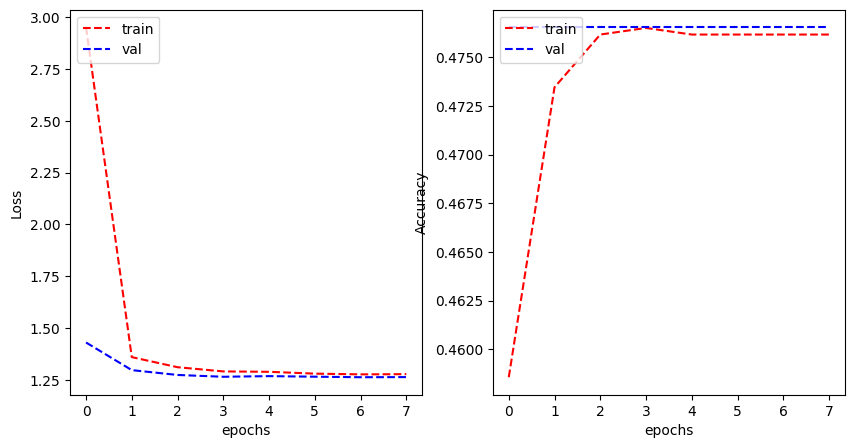

In [61]:
plot_learning_curve(history_VGG3_shape_tuning.history['loss'], history_VGG3_shape_tuning.history['val_loss'],
                    history_VGG3_shape_tuning.history['accuracy'], history_VGG3_shape_tuning.history['val_accuracy'],
                    metric_name='Accuracy')

In [62]:
dropout_rate = 0.02

In [ ]:
# A full model performance evaluation of `model_VGG3` based on test data:
from keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, BatchNormalization

reg_lambda = 0.002
dropout_rate = 0.02

model_VGG3_shape = tf.keras.Sequential([
    #VGG block 1
    tf.keras.layers.Conv2D(32, (3, 3), activation='relu', padding='same',
                           kernel_regularizer=tf.keras.regularizers.l2(reg_lambda), input_shape=(28, 28, 1)),
    tf.keras.layers.Conv2D(32, (3, 3), activation='relu', padding='same',
                           kernel_regularizer=tf.keras.regularizers.l2(reg_lambda)),
    tf.keras.layers.MaxPooling2D((2, 2)),

    #VGG block 2
    tf.keras.layers.Conv2D(64, (3, 3), activation='relu', padding='same',
                           kernel_regularizer=tf.keras.regularizers.l2(reg_lambda)),
    tf.keras.layers.Conv2D(64, (3, 3), activation='relu', padding='same',
                           kernel_regularizer=tf.keras.regularizers.l2(reg_lambda)),
    tf.keras.layers.MaxPooling2D((2, 2)),

    #VGG block 3
    tf.keras.layers.Conv2D(128, (3, 3), activation='relu', padding='same',
                           kernel_regularizer=tf.keras.regularizers.l2(reg_lambda)),
    tf.keras.layers.Conv2D(128, (3, 3), activation='relu', padding='same',
                           kernel_regularizer=tf.keras.regularizers.l2(reg_lambda)),
    tf.keras.layers.MaxPooling2D((2, 2)),

    # Dense Layers
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(128, activation='relu'),
    tf.keras.layers.Dropout(dropout_rate),
    tf.keras.layers.Dense(OUTPUT_CLASSES_SHAPE),
])

# Train the model and evaluate its performance
model_VGG3_shape.compile(optimizer='adam',
                   loss=tf.keras.losses.CategoricalCrossentropy(from_logits=True),
                   metrics=['accuracy'])

history_VGG3_shape = model_VGG3_shape.fit(train_generator_shape, validation_data = validation_generator_shape, epochs=10, verbose=1)


Epoch 1/10
93/93 [==============================] - 35s 358ms/step - loss: 1.5044 - accuracy: 0.5198 - val_loss: 0.8700 - val_accuracy: 0.7491
Epoch 2/10
93/93 [==============================] - 32s 338ms/step - loss: 0.5172 - accuracy: 0.8972 - val_loss: 0.3360 - val_accuracy: 0.9477
Epoch 3/10
93/93 [==============================] - 30s 321ms/step - loss: 0.2583 - accuracy: 0.9689 - val_loss: 0.2165 - val_accuracy: 0.9801
Epoch 4/10
93/93 [==============================] - 29s 309ms/step - loss: 0.2187 - accuracy: 0.9784 - val_loss: 0.2120 - val_accuracy: 0.9819
Epoch 5/10
14/93 [===>..........................] - ETA: 24s - loss: 0.1724 - accuracy: 0.9844

In [ ]:
plot_learning_curve(history_VGG3_shape.history['loss'], history_VGG3_shape.history['val_loss'],
                    history_VGG3_shape.history['accuracy'], history_VGG3_shape.history['val_accuracy'],
                    metric_name='Accuracy')

In [ ]:

from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix, accuracy_score, f1_score

y_hat_all = list()
y_all = list()
filenames = test_generator_shape.filenames
N_images = len(filenames)
batches = 0

for x,y in test_generator_shape:
        y_hat = model_VGG3_shape.predict(x, verbose=0)
        y_hat = np.argmax(y_hat, axis = 1)
        y = np.argmax(y, axis = 1)
        y_hat_all = y_hat_all + y_hat.tolist()
        y_all = y_all + y.tolist()

        batches += 1
        if batches >= N_images / batch_size:
            break

print("Evaluate the final performance of VGG3 model based on test data:")
print("Accuracy score: ", accuracy_score(y_all, y_hat_all))
#print("F1 score: ", f1_score(y_all, y_hat_all, average='macro'))
print("F1 score: ", f1_score(y_all, y_hat_all, average='macro', zero_division=1))
print(confusion_matrix(y_all, y_hat_all))
print(classification_report(y_all,y_hat_all))

In [ ]:
# Parameter tuning for reducing model complexity
reg_lambda = 0.002
dropout_rate = 0.5

# Define the range of neurons to test
neurons_list = [32, 64, 128, 256, 512]

best_performance = 0.0
best_neurons = None
model_test_acc = None
model_train_acc = None

for neurons in neurons_list:
    model_VGG4_shape_tuning = tf.keras.Sequential([
        tf.keras.layers.Conv2D(32, (3, 3), activation='relu', padding='same',
                               kernel_regularizer=tf.keras.regularizers.l2(reg_lambda), input_shape=(27, 27, 3)),
        tf.keras.layers.MaxPooling2D((2, 2)),

        tf.keras.layers.Conv2D(64, (3, 3), activation='relu', padding='same',
                               kernel_regularizer=tf.keras.regularizers.l2(reg_lambda)),
        tf.keras.layers.MaxPooling2D((2, 2)),

        tf.keras.layers.Conv2D(128, (3, 3), activation='relu', padding='same',
                               kernel_regularizer=tf.keras.regularizers.l2(reg_lambda)),
        tf.keras.layers.MaxPooling2D((2, 2)),

        tf.keras.layers.Flatten(),
        # reduce the number of neurons in the Dense layer
        tf.keras.layers.Dense(neurons, activation='relu'),
        tf.keras.layers.Dropout(dropout_rate),
        tf.keras.layers.Dense(OUTPUT_CLASSES_SHAPE)
    ])

    # Compile the model
    model_VGG4_shape_tuning.compile(optimizer='adam',
                  loss=tf.keras.losses.CategoricalCrossentropy(from_logits=True),
                  metrics=['accuracy'])

    print(f"Training model with {neurons} neurons.")
    # Train the model on the training data
    history_VGG4_shape_tuning = model_VGG4_shape_tuning.fit(train_generator_shape, validation_data=validation_generator_shape, epochs=10, verbose=1)


In [ ]:
# evaluate the model performance
train_accuracy_VGG4_shape_tuning = history_VGG4_shape_tuning.history['accuracy'][-1]
train_loss_VGG4_shape_tuning = history_VGG4_shape_tuning.history['loss'][-1]  # Retrieve the last training loss
val_accuracy_VGG4_shape_tuning = history_VGG4_shape_tuning.history['val_accuracy'][-1]
val_loss_VGG4_shape_tuning = history_VGG4_shape_tuning.history['val_loss'][-1]  # Retrieve the last validation loss
test_loss_VGG4_shape_tuning, test_accuracy_VGG4_shape_tuning = model_VGG3_shape_tuning.evaluate(test_generator_shape, verbose=0)

print(f"neurons = {neurons}, train_loss = {train_loss_VGG4_shape_tuning}, train_accuracy = {train_accuracy_VGG4_shape_tuning}, val_loss = {val_loss_VGG4_shape_tuning}, val_accuracy = {val_accuracy_VGG4_shape_tuning}, test_accuracy = {test_accuracy_VGG4_shape_tuning}\n")

# Update the best performance and regularization lambda
if val_accuracy_VGG4_shape_tuning > best_performance:
  best_performance = val_accuracy_VGG4_shape_tuning
  best_reg_lambda = reg_lambda
  model_train_acc = train_accuracy_VGG4_shape_tuning
  model_test_acc = test_accuracy_VGG4_shape_tuning

In [ ]:
# Print the best accuracy and the corresponding number of neurons
print(f"Best model performance:")
print(f"Best number of neurons: {best_neurons} based on validation accuracy: {best_performance} \nwhere train_accuracy: {train_accuracy_VGG4_shape_tuning} and test accuracy: {test_accuracy_VGG4_shape_tuning} \nregularization lambda: {reg_lambda} and dropout rate: {dropout_rate}")

In [ ]:
plot_learning_curve(history_VGG4_shape_tuning.history['loss'], history_VGG4_shape_tuning.history['val_loss'],
                    history_VGG4_shape_tuning.history['accuracy'], history_VGG4_shape_tuning.history['val_accuracy'],
                    metric_name='Accuracy')

## **Normalization**

Updated Model with L2 Regularization, Dropout, and Batch Normalization.

- **L2 Regularization:** Apply to
convolutional and dense layers.

- **Dropout:** Add after each max pooling and dense layer.

- **Batch Normalization:** Add after each convolutional layer.


In [ ]:
# from keras import regularizers
# from keras.models import Sequential
# from keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, BatchNormalization

# # Define the regularization parameter
# sample_lambda = 0.01



# # Define the CNN model with regularization for shape classification
# model_cnn_shape_reg = Sequential()
# model_cnn_shape_reg.add(Conv2D(32, kernel_size=(3, 3), activation='relu',
#                                 kernel_regularizer=regularizers.l2(sample_lambda),
#                                 input_shape=INPUT_DIM))
# model_cnn_shape_reg.add(BatchNormalization())
# model_cnn_shape_reg.add(Dropout(0.25))
# model_cnn_shape_reg.add(MaxPooling2D(pool_size=(2, 2)))

# model_cnn_shape_reg.add(Conv2D(64, kernel_size=(3, 3), activation='relu',
#                                 kernel_regularizer=regularizers.l2(sample_lambda)))
# model_cnn_shape_reg.add(BatchNormalization())
# model_cnn_shape_reg.add(Dropout(0.25))
# model_cnn_shape_reg.add(MaxPooling2D(pool_size=(2, 2)))

# model_cnn_shape_reg.add(Conv2D(128, kernel_size=(3, 3), activation='relu',
#                                 kernel_regularizer=regularizers.l2(sample_lambda)))
# model_cnn_shape_reg.add(BatchNormalization())
# model_cnn_shape_reg.add(Dropout(0.4))
# model_cnn_shape_reg.add(MaxPooling2D(pool_size=(2, 2)))

# model_cnn_shape_reg.add(Flatten())
# model_cnn_shape_reg.add(Dense(128, activation='relu',
#                               kernel_regularizer=regularizers.l2(sample_lambda)))
# model_cnn_shape_reg.add(BatchNormalization())
# model_cnn_shape_reg.add(Dropout(0.3))
# model_cnn_shape_reg.add(Dense(OUTPUT_CLASSES_SHAPE, activation='softmax'))

# model_cnn_shape_reg.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])


In [ ]:
# history_CNN_shape_reg = model_cnn_shape_reg.fit(train_generator_shape, validation_data = validation_generator_shape, epochs=10, verbose=1)

In [ ]:
# plot_learning_curve(history_CNN_shape_reg.history['loss'], history_CNN_shape_reg.history['accuracy'],
#                     history_CNN_shape_reg.history['val_loss'], history_CNN_shape_reg.history['val_accuracy'],
#                     metric_name='Accuracy')

In [ ]:
# # Evaluate the model on the training data
# train_loss_CNN_shape_reg, train_accuracy_CNN_shape_reg = model_cnn_shape_reg.evaluate(train_generator_shape)
# print("Training Data for Shapes - Loss: {:.4f}, Accuracy: {:.4f}".format(train_loss_CNN_shape_reg, train_accuracy_CNN_shape_reg))

# # Evaluate the model on the validation data
# val_loss_CNN_shape_reg, val_accuracy_CNN_shape_reg = model_cnn_shape_reg.evaluate(validation_generator_shape)
# print("Validation Data for Shapes - Loss: {:.4f}, Accuracy: {:.4f}".format(val_loss_CNN_shape_reg, val_accuracy_CNN_shape_reg))

# # Evaluate the model on the testing data
# test_loss_CNN_shape_reg, test_accuracy_CNN_shape_reg = model_cnn_shape_reg.evaluate(test_generator_shape)
# print("Testing Data for Shapes - Loss: {:.4f}, Accuracy: {:.4f}".format(test_loss_CNN_shape_reg, test_accuracy_CNN_shape_reg))


In [ ]:
# model_result(train_generator_shape, validation_generator_shape, history_CNN_shape_reg)

# **Data Augmentation**

**Recognizing the imbalance in our data, we plan to explore whether supplementing the smaller classes with augmented data can enhance the accuracy of our model. In this section, we will establish new folders to house the augmented datasets derived from the original training data.**

In [ ]:
# Determine the maximum count in any single category
max_count = max([len(group) for label, group in shape_groups])

# Calculate augmentation needs for each category
augment_needs = {}
for label, group in shape_groups:
    current_count = len(group)
    augment_needs[label] = max(0, max_count - current_count)  # Only augment if needed


In [ ]:
max_count

In [ ]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import cv2
import numpy as np

# Initialize the ImageDataGenerator with transformations
datagen = ImageDataGenerator(
    rotation_range=20,
    width_shift_range=0.1,
    height_shift_range=0.1,
    horizontal_flip=True,
    vertical_flip=True,
    zoom_range=0.1,
    fill_mode='nearest'
)

# Augment the images based on their needs
augmented_images = []
for label, group in shape_groups:
    images = [cv2.imread(path, cv2.IMREAD_GRAYSCALE) for path in group['image_path']]
    num_to_augment = augment_needs[label]
    augmented_count = 0

    for img in images:
        if augmented_count >= num_to_augment:
            break
        img = cv2.resize(img, (28, 28))
        img = img.reshape(1, 28, 28, 1)  # Reshape to fit the ImageDataGenerator requirements
        aug_iter = datagen.flow(img, batch_size=1)

        for _ in range(5):  # Generate multiple augmented images from each original image
            aug_img = next(aug_iter)[0]
            augmented_images.append(aug_img)
            augmented_count += 1
            if augmented_count >= num_to_augment:
                break


In [ ]:
# Initialize shape_counts for both 'original' and 'augmented'
shape_counts = {label: {'original': 0, 'augmented': 0} for label in shape_groups.groups.keys()}
# Split each shape group into training and testing sets and update counts
for label, group in shape_groups:
    X_train, X_test, y_train, y_test = train_test_split(
        group['image_path'], group['encoded_shape_label'], test_size=0.2, stratify=group['shape_label'])
    shape_counts[label]['original'] += len(X_train)  # Update original count with the number of training images
    print(f"Shape group label: {label}, Train: {len(X_train)}, Test: {len(X_test)}")
# Assuming you track augmented images correctly
for label, group in shape_groups:
    # Simulate augmenting images
    num_augments = 5 * len(X_train)  # Assuming you augment each image 5 times
    shape_counts[label]['augmented'] += num_augments  # Update augmented count
# Plotting the distribution of images for shapes
labels, original_counts, augmented_counts = zip(*[
    (label, counts['original'], counts['augmented']) for label, counts in shape_counts.items()
])

indexes = np.arange(len(labels))
width = 0.35

plt.bar(indexes, original_counts, width, label='Original')
plt.bar(indexes + width, augmented_counts, width, label='Augmented', color='red')

plt.ylabel('Number of Images')
plt.title('Number of Images by Shape Before and After Augmentation')
plt.xticks(indexes + width / 2, labels, rotation='vertical')
plt.legend()
plt.show()


**Observations:**

- After applying augmentation, the number of images in each shape category is now balanced.
- This augmentation approach can potentially improve the performance of a machine-learning model trained on this data by providing more representative data for each shape class.

In [ ]:
# Initialize type_counts for both 'original' and 'augmented'
type_counts = {label: {'original': 0, 'augmented': 0} for label in type_groups.groups.keys()}
# Split each type group into training and testing sets and update counts
for label, group in type_groups:
    X_train, X_test, y_train, y_test = train_test_split(
        group['image_path'], group['encoded_type_label'], test_size=0.2, stratify=group['type_label'])
    type_counts[label]['original'] += len(X_train)  # Update original count with the number of training images
    print(f"type group label: {label}, Train: {len(X_train)}, Test: {len(X_test)}")
# Assuming you track augmented images correctly
for label, group in type_groups:
    # Simulate augmenting images
    num_augments = 5 * len(X_train)  # Assuming you augment each image 5 times
    type_counts[label]['augmented'] += num_augments  # Update augmented count
# Plotting the distribution of images for shapes
labels, original_counts, augmented_counts = zip(*[
    (label, counts['original'], counts['augmented']) for label, counts in type_counts.items()
])

indexes = np.arange(len(labels))
width = 0.35

plt.bar(indexes, original_counts, width, label='Original')
plt.bar(indexes + width, augmented_counts, width, label='Augmented', color='red')

plt.ylabel('Number of Images')
plt.title('Number of Images by Type Before and After Augmentation')
plt.xticks(indexes + width / 2, labels, rotation='vertical')
plt.legend()
plt.show()

**Observations:**

- After applying augmentation, the number of images in each type category is now more balanced.
- This augmentation approach can potentially improve the performance of a
machine-learning model trained on this data by providing more representative data for each type class.


# **3. Type Classification**

Drop out